<font color="#483D8B">
<h1  align="left">     AWS - Distributed Deep Learning and Neural Networks</h1>
<div align="left">
<font size=3><b>
<br>Lab 10
<br>Kevin Yang
<br>April 14, 2019
<br></font></b></div>


---------------

## Overview

This lab will include executing model in a distributed, scaled out environment. It will also perform image captioning using a built hybrid LSTM pre-trained-VGG model. It will cover how distributed deep learning and neural networks operate through a cloud-based environment with Amazon web services. 

References:
1. https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8
2. https://docs.google.com/document/d/1DGekkWYgcuqhBhZARHH5QGRugaWSsHcfbnJCrK-ue9I/edit#
3. https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/ (article and direct link to Flickr8k dataset)
4. https://nlp.stanford.edu/projects/glove/ (Link to download the GloVe dataset) 

In [4]:
import string
from pickle import load
from keras.applications import InceptionV3
from keras.models import Model
from keras.preprocessing import image 
from os import listdir
import numpy as np
from keras.applications.resnet50 import preprocess_input, decode_predictions

Using TensorFlow backend.


## Data

In [31]:
# Below is the path for the file "Flickr8k.token.txt" on your disk
filename = "C:/Users/kyang/Desktop/L10/ftext/Flickr8k.token.txt"
file = open(filename, 'r')
doc = file.read()

filename2 = 'C:/Users/kyang/Desktop/L10/glove/glove.6B.50d.txt'
file2 = open(filename2, 'r', encoding="utf8")
doc2 = file2.read()


'Flickr8' and the 'glove6b' dataset will be utilized for this lab. Both datasets can be found and downloaded from links the reference section. 'filename' contains the Flickr8k dataset. 'filename2' contains the glove dataset. 

## Exploratory Data Analysis

In [19]:
#def load_descriptions(doc):
descriptions = dict()
for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    
    if len(line) < 2:
        continue
    
    # take the first token as image id, the rest as description
    image_id, image_desc = tokens[0], tokens[1:]
    
    # extract filename from image id
    image_id = image_id.split('.')[0]
    
    # convert description tokens back to string
    image_desc = ' '.join(image_desc)
    if image_id not in descriptions:
        descriptions[image_id] = list()
    descriptions[image_id].append(image_desc)

Above displays line splitting by the endline from the flickr text file. Image id and descriptions are separated into their own separate rokens. Image id is separated by '.' and the descriptions is converted back into a string.

In [20]:
# prepare translation table for removing punctuation

table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        # tokenize
        desc = desc.split()
        # convert to lower case
        desc = [word.lower() for word in desc]
        # remove punctuation from each token
        desc = [w.translate(table) for w in desc]
        # remove hanging 's' and 'a'
        desc = [word for word in desc if len(word)>1]
        # remove tokens with numbers in them
        desc = [word for word in desc if word.isalpha()]
        # store as string
        desc_list[i] =  ' '.join(desc)

Above prepares the translation table for removing punctuations. 

In [21]:
vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


We can see that the set of vocabulary is 8763. There are 8763 words in the description.

In [22]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [23]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
 
# save descriptions
save_descriptions(descriptions, 'descriptions.txt')

'load_doc' is a function that load the file into memory. 'save_descriptions' is a function that writes the descriptions from the file into a new text file: descriptions.txt.

In [41]:

def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [25]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

train = load_set(filename)
train_descriptions = load_clean_descriptions('descriptions.txt', train)

'load_set' loads a pre-defined list of photo identifiers. 'load_clean_descriptions' load descriptions of each image into a dictionary labeled 'descriptions'. 'train' contains the loaded set of the flickr textfile. 'train_descriptions' contains the image descriptions from the flickr file. 

In [26]:
# Create a list of all the training captions

all_train_captions = []

for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0

for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
        
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ' % len(vocab))

preprocessed words 1949 


In [27]:
#Loading TrainingSet

In [34]:

#newfile = file(filename2)
train = list()
for line in doc2.split('\n'):
    identifier = line.split('.')[0]
    train.append(identifier)
print('Dataset: %d' % len(train))

Dataset: 400001


In [35]:
doc = load_doc('descriptions.txt')

train_descriptions = dict()

for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()

    # split id from description
    image_id, image_desc = tokens[0], tokens[1:]

    # skip images not in the set
    if image_id in train_descriptions:
        if image_id not in descriptions:
            train_descriptions[image_id] = list()

        # wrap description in tokens
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'

        # store
        train_descriptions[image_id].append(desc)
        print('Descriptions: train=%d' % len(train_descriptions))

In [36]:
#Data Preprocessing-Images

In [37]:
# Get the InceptionV3 model trained on imagenet data
model = InceptionV3(weights='imagenet')
# Remove the last layer (output softmax layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

Instructions for updating:
Colocations handled automatically by placer.


## Conclusion

## Appendix

In [1]:
import matplotlib.pyplot as plt

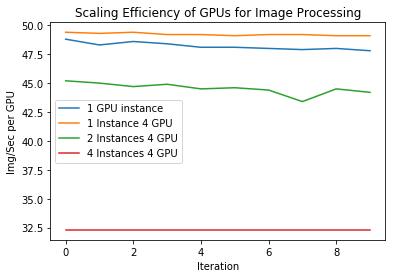

In [2]:
# line 1 points 
x1 = [0,1,2,3,4,5,6,7,8,9] 
y1 = [48.8,48.3,48.6,48.4,48.1,48.1,48.0,47.9,48.0,47.8] 
# plotting the line 1 points  
plt.plot(x1, y1, label = "1 GPU instance") 
  
# line 2 points 
x2 = [0,1,2,3,4,5,6,7,8,9]
y2 = [49.4,49.3,49.4,49.2,49.2,49.1,49.2,49.2,49.1,49.1] 
# plotting the line 2 points  
plt.plot(x2, y2, label = "1 Instance 4 GPU") 

# line 3 points 
x3 = [0,1,2,3,4,5,6,7,8,9]
y3 = [45.2,45.0,44.7,44.9,44.5,44.6,44.4,43.4,44.5,44.2]
# plotting the line 2 points  
plt.plot(x3, y3, label = "2 Instances 4 GPU") 

# line 2 points 
x4 = [0,1,2,3,4,5,6,7,8,9]
y4 = [32.3,32.3,32.3,32.3,32.3,32.3,32.3,32.3,32.3,32.3] 
# plotting the line 2 points  
plt.plot(x4, y4, label = "4 Instances 4 GPU") 

# naming the x axis 
plt.xlabel('Iteration') 
# naming the y axis 
plt.ylabel('Img/Sec per GPU') 
# giving a title to my graph 
plt.title('Scaling Efficiency of GPUs for Image Processing') 
  
# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show() 

1. Was there any difference between the first baseline test with only 1 instance running and the first baseline test with 4 GPUs running?
   
    The first baseline test(1 GPU instance) perform much slower than the other first baseline test(1 Instance 4 GPU) with 4 GPUs running. The first baseline test with 4 GPUs performs better in terms of Img/sec per GPU over the 10 iterations. We can see that the Img/sec per GPU performance decreases for the first baseline with 1 instance. The first baseline with 4 GPUs  stays near consistent in regards to img/sec performance while the other first baseline drops sharply at the 1st iteration. 
   
   
2. Does the number of images processed/second scale linearly as more GPUs are added? Explain. 

    Yes the number of images processed/second scale linearly as more GPUs are added. We can see that with 4 GPU-enabled instances it is completely linear for all iterations at 32.5 Img/sec per GPU. Although at 2 GPU-enabled instances, it is not as linear with performance averaging at 89.1 +-1.8. We can predict based on the first, second, and fourth instances(with more GPUs) that performance will decrease for each instance, but eventually it will stabilize and scale linearly at a lower image processing speed as displayed by the 4th instance.  